In [1519]:
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import scipy
from scipy.spatial import Delaunay
from scipy.optimize import root

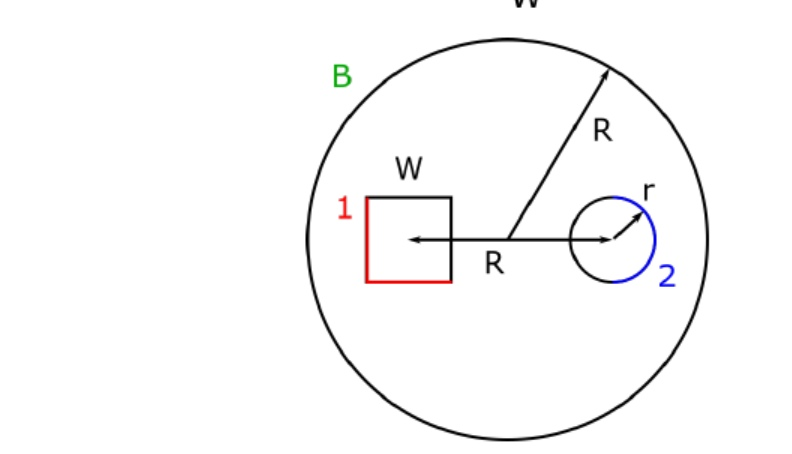

In [1520]:
Image(filename='1.jpg') 

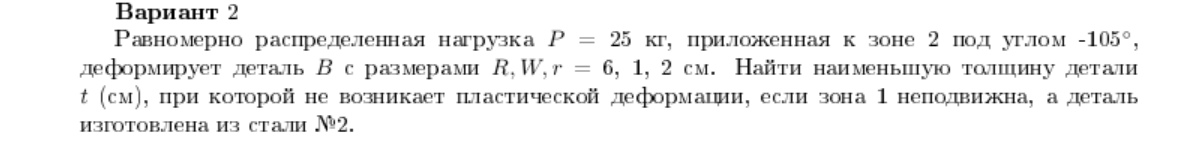

In [1521]:
Image(filename='2.jpg') 

In [1522]:
W = 2
R = 6
r = 2
g = 0.25

In [1523]:
#все в ньютонах на сантиметр в квадрате
E = 21000000
mu = 0.29
sigma = 60000
P = (25*10)/(np.pi*R**2 - np.pi*r**2 - W**2)

In [1524]:
# внешняя граница
alpha = np.arange(0, 2*np.pi, g/R)
G0x = R*np.cos(alpha)
G0y = R*np.sin(alpha)
Gout = np.vstack((G0x, G0y)).T



In [1525]:
G1y = np.arange(0, W, g) - (W)/2
G1x = np.zeros_like(G1y)  - (W + R)/2

G2x = np.arange(0, W, g) - (R + W)/2
G2y = np.zeros_like(G2x) + (W)/2

G3y = np.arange(W, 0, -g) - (W)/2
G3x = np.zeros_like(G3y) - (R - W)/2

G4x = np.arange(W, 0, -g)  - (R + W)/2
G4y = np.zeros_like(G4x)  - (W)/2

In [1526]:
alpha = np.arange(0, 2*np.pi, g/r)
G5x = R/2 + r*np.cos(alpha)
G5y = r*np.sin(alpha)

In [1527]:
# внутренняя граница
Gin0 = np.vstack((
                    np.vstack((G1x, G1y)).T,
                    np.vstack((G2x, G2y)).T,
                    np.vstack((G3x, G3y)).T,
                    np.vstack((G4x, G4y)).T,
                   
                   ))

Gin1 =  np.vstack((G5x, G5y)).T

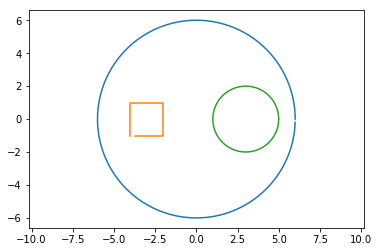

In [1528]:
plt.plot(Gout[:,0], Gout[:,1])
plt.plot(Gin0[:,0], Gin0[:,1])
plt.plot(Gin1[:,0], Gin1[:,1])
plt.axis('equal');

In [1529]:
margin = 0.1

In [1530]:
x = np.linspace(-R-margin, R-margin, 40)
y = np.linspace(-R-margin, R-margin, 40)
X, Y = np.meshgrid(x, y)

In [1531]:
INodes = np.vstack((X.ravel(), Y.ravel())).T
# прямое вычисление маски

xdata = X.ravel()
ydata = Y.ravel()

#imask0 = (xdata > (- (W + R)/2)) & (xdata < (- (R - W)/2)) & (ydata > (- (W)/2)) & (ydata < (W)/2)

imask1 = np.sum((INodes - np.array([R/2, 0]))**2,axis=1) >= (r)**2

imask2 = np.sum((INodes )**2,axis=1) < (R)**2
INodes = INodes[imask1 & imask2]
INodes.shape

(1067, 2)

In [1532]:
path = Path(Gin0)
imask0 = np.logical_not(path.contains_points(INodes, radius = 0.001))
INodes = INodes[imask0]

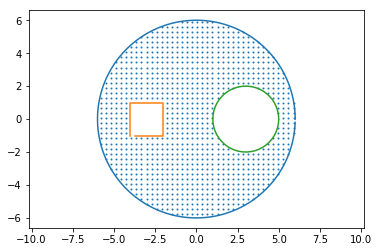

In [1533]:
plt.plot(Gout[:,0], Gout[:,1])
plt.plot(Gin0[:,0], Gin0[:,1])
plt.plot(Gin1[:,0], Gin1[:,1])
plt.scatter(INodes[:,0], INodes[:,1], s=1)
plt.axis('equal');

In [1534]:
Nodes = np.vstack((Gout, Gin0, Gin1, INodes))

In [1535]:
tri = Delaunay(Nodes)
Elems = tri.simplices.copy()

In [1536]:
Elems = tri.simplices.copy()
emask = np.any(Elems >= Nodes.shape[0] - INodes.shape[0], axis=1)
Elems = Elems[emask]

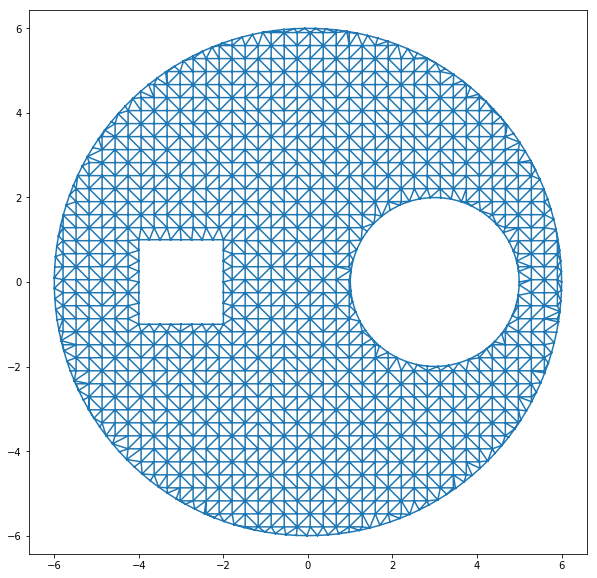

In [1537]:
plt.figure(figsize=(10,10))
plt.triplot(Nodes[:,0], Nodes[:,1], Elems)
plt.axis('equal');

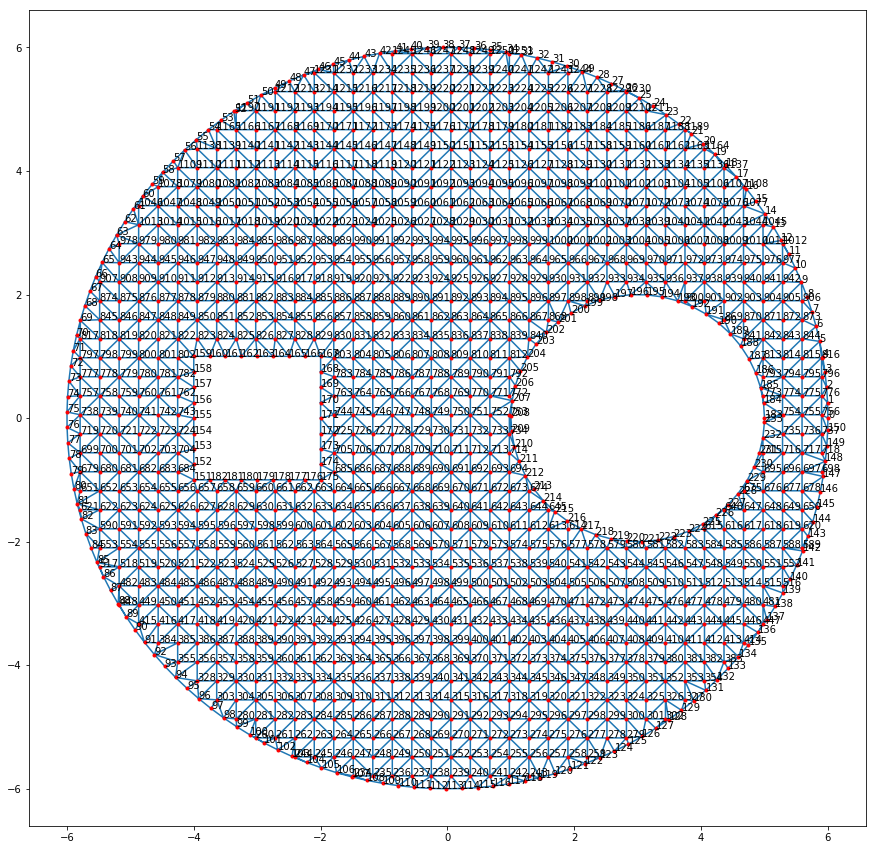

In [1538]:
plt.figure(figsize = (15, 15));
plt.triplot(Nodes[:,0], Nodes[:,1], Elems);
plt.plot(Nodes[:,0], Nodes[:,1], '.', color = 'red')
for i, Node in enumerate(Nodes):
    plt.text(Node[0], Node[1], s=i)
    
plt.show()

In [1539]:
Coords = Nodes[Elems]
A = 0.5 * np.cross(Coords[:,1] - Coords[:,0], Coords[:,2] - Coords[:,0])
b = np.roll(Coords[:,:,1], -1, axis = 1) - np.roll(Coords[:,:,1], 1, axis = 1)
c = np.roll(Coords[:,:,0], 1, axis = 1) - np.roll(Coords[:,:,0], -1, axis = 1)

In [1540]:
B = np.zeros((Elems.shape[0],3,6))

B[:,0,0::2] = b
B[:,1,1::2] = c

B[:,2,1::2] = b
B[:,2,0::2] = c

B *= 1/(2*A[:,None,None])
Bt = np.transpose(B, axes=(0,2,1))

In [1541]:
D = (E/(1 - mu**2)) * np.array([[1, mu, 0], [mu, 1, 0], [0, 0, (1 - mu)/2]])

In [1542]:
Bt = np.zeros([len(A), 6, 3])

for i in range (0, len(A)):
    prom = np.array([[b[i][0], 0, b[i][1], 0, b[i][2], 0],
                        [0, c[i][0], 0, c[i][1], 0, c[i][2]],
                        [c[i][0], b[i][0], c[i][1], b[i][1], c[i][2], b[i][2]]])
    
    Bt[i] = (1/(2*A[i]))*prom.T

In [1543]:
Ke = Bt@D@B

In [1544]:
EFT = 2*Elems[:, [0,0,1,1,2,2]] + np.array([0,1,0,1,0,1])

In [1545]:
K = np.zeros((2*Nodes.shape[0],)*2)

In [1546]:
for i, e in enumerate(Elems):
    K[EFT[i,None].T, EFT[i]] += Ke[i]

inf


/Users/deniszagorodnev/.local/lib/python3.6/site-packages/numpy/linalg/linalg.py:2093: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


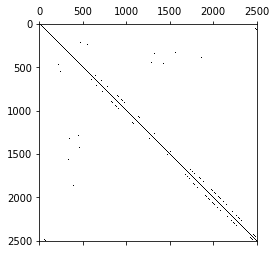

In [1547]:
print(np.linalg.det(K))
plt.spy(K)

In [1548]:
F = np.zeros(2*Nodes.shape[0])

In [1549]:
def aim_function_2(t):

    #force
    alpha = np.deg2rad(-105)
    px, py = P*np.cos(alpha), P*np.sin(alpha)

    bc_force = np.array(list(np.arange(221, 232) ) + list(np.arange(183, 195)))
    bc_fixed = np.array(list(np.arange(151, 158) ) + list(np.arange(176, 182)))
    dof = np.hstack((bc_fixed*2, bc_fixed*2+1))
    bc = {'zero':dof, 'pressure':(bc_force, (px, py))}
    
    F = np.zeros(Nodes.shape[0]*2)
    bc_force, f = bc['pressure']
    L_p = np.linalg.norm(Nodes[bc_force[1:]] - Nodes[bc_force[:-1]], axis=1)
    for i in range(len(L_p)):
        F[bc_force[[i, i+1]]*2] += L_p[i]*t*P*0.5    
    dof = bc['zero']
    K[dof, :] = 0
    K[:, dof] = 0
    K[dof, dof] = 1
    F[dof] = 0
    
        
    U = np.linalg.solve(K, F)
    
    return min(U)

res = scipy.optimize.minimize(aim_function_2, 50000, bounds = ((0, 1000000),))

print('минимальная толщина детали в см: ', -aim_function_2(res.x))


минимальная толщина детали в см:  0.005583046477346353


In [1550]:
#пересчет на узлы для контурной карты
def calcNodeSig(U, EFT, B, D, A, Nn, Elems):
    ElemU = U[EFT, np.newaxis]
    ElemEps = np.matmul(B, ElemU)
    ElemSig = np.matmul(D, ElemEps)
    NodeSig = np.zeros((Nn, 3))
    NodeA = np.zeros(Nn)

    for i in range(Elems.shape[0]):
        NodeSig[Elems[i]] += ElemSig[i].T * A[i]
        NodeA[Elems[i]] += A[i]
    NodeSig /= NodeA.reshape(-1,1)
    return NodeSig



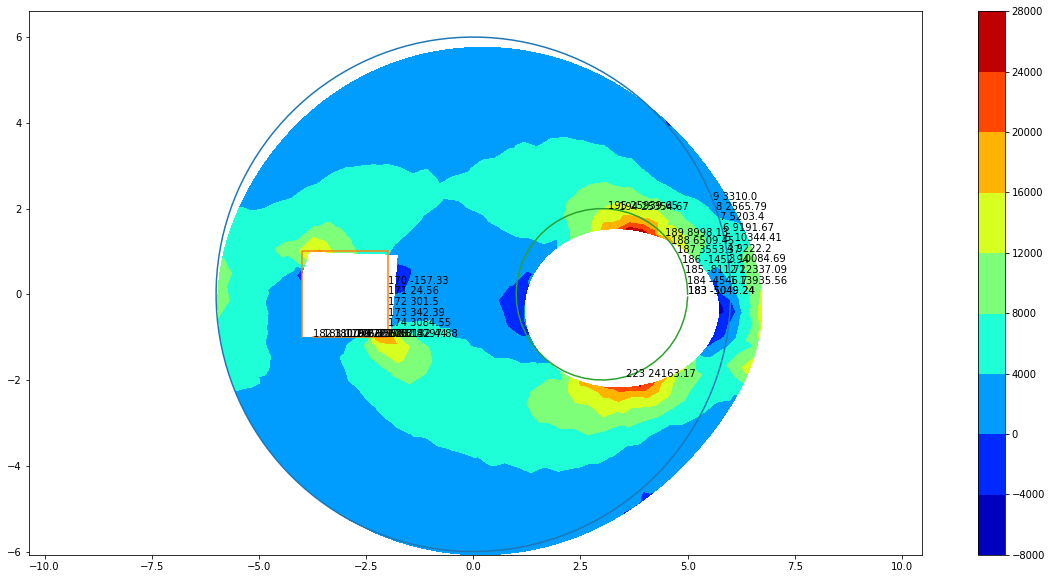

In [1551]:
alpha = np.deg2rad(-105)

p_max = sigma/2

t = res.x

px, py = P*np.cos(alpha), P*np.sin(alpha)

bc_force = np.array(list(np.arange(221, 232) ) + list(np.arange(183, 195)))
bc_fixed = np.array(list(np.arange(151, 158) ) + list(np.arange(176, 182)))


dof = np.hstack((bc_fixed*2, bc_fixed*2+1))
bc = {'zero':dof, 'pressure':(bc_force, (px, py))}
    
F = np.zeros(Nodes.shape[0]*2)
bc_force, f = bc['pressure']
L_p = np.linalg.norm(Nodes[bc_force[1:]] - Nodes[bc_force[:-1]], axis=1)
for i in range(len(L_p)):
    F[bc_force[[i, i+1]]*2] += L_p[i]*t*P*0.5    
dof = bc['zero']
K[dof, :] = 0
K[:, dof] = 0
K[dof, dof] = 1
F[dof] = 0   

    
U = np.linalg.solve(K, F)

NodeSig = calcNodeSig(U, EFT, B, D, A, Nodes.shape[0], Elems)
S0_node = 0.5*(NodeSig[:,0] + NodeSig[:,1]) +  ((0.5*(NodeSig[:,0] - NodeSig[:,1]))**2 + NodeSig[:,2]**2)**0.5

rNodes = Nodes + 100*U.reshape(-1, 2)
    
Eps = B@U[EFT, None]
Sig = D@Eps
    
M = np.array([  [Sig[0, 0, 0],  Sig[0, 2, 0]],   [Sig[0, 2, 0],  Sig[0, 1, 0]]]  )
S0 = 0.5*(Sig[:,0] + Sig[:,1]) +  ((0.5*(Sig[:,0] - Sig[:,1]))**2 + Sig[:,2]**2)**0.5
S1 = 0.5*(Sig[:,0] + Sig[:,1]) -  ((0.5*(Sig[:,0] - Sig[:,1]))**2 + Sig[:,2]**2)**0.5

plt.figure(figsize=(20,10))


#первые три самые горячие и самая холодная точка
srtd = sorted(S0_node)
frst = srtd[-1]
scnd = srtd[-2]
thrd = srtd[-3]
frth = srtd[0]

ind_1 = list(S0_node).index(frst)
ind_2 = list(S0_node).index(scnd)
ind_3 = list(S0_node).index(thrd)
ind_4 = list(S0_node).index(min(srtd))

for i, Node in enumerate(Nodes):
    if i in fixed or i in force:
        plt.text(Node[0], Node[1], s= str(i) + ' ' + str(round(S0_node[i], 2)))

for i, Node in enumerate(Nodes):
    if i == ind_1 or i == ind_2 or i == ind_3 or i == ind_4:
        plt.text(Node[0], Node[1], s= str(i) + ' ' + str(round(S0_node[i], 2)))



#cont = plt.tripcolor(rNodes[:, 0], rNodes[:, 1], Elems, S0_node, cmap = 'jet');
cont = plt.tricontourf(rNodes[:, 0], rNodes[:, 1], Elems, S0_node, cmap='jet')

plt.plot(Gout[:,0], Gout[:,1])
plt.plot(Gin0[:,0], Gin0[:,1])
plt.plot(Gin1[:,0], Gin1[:,1])

plt.colorbar(cont)
plt.axis('equal')
plt.show()


